In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Input,Embedding, Dropout,Bidirectional, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# UTILITY FUNCTIONS FOR PREPROCESSING AND OTHER TASKS

In [ ]:
def preprocess_tweet(text):
    #Convert to lowercasetext = text.lower();
    text=text.lower();
    #Regex to remove unecessary charcters
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text).strip()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the processed tokens back into a text string
    processed_text = ' '.join(tokens)
    return processed_text


# Loading Data


In [77]:
from google.colab import drive
drive.mount('/content/drive')

train_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Corona_NLP_train.csv",encoding='latin1')

test_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Corona_NLP_test.csv",encoding='latin1')

ModuleNotFoundError: No module named 'google.colab'

In [78]:
train_df=pd.read_csv("Corona_NLP_train.csv", encoding='latin1')

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [79]:
test_df=pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [80]:
print("Information about Training Data\n")
train_df.info()

print("Information about Testing Data\n")
test_df.info()

Information about Training Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
Information about Testing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 n

In [84]:
print("Training Shape: ", train_df.shape)
print("Testing Shape: ", test_df.shape)

Training Shape:  (41157, 6)
Testing Shape:  (3798, 6)


In [108]:
df = pd.concat([train_df, test_df])
df.columns

AttributeError: 'Index' object has no attribute 'dtypes'

# Pre-Processing Data

In [86]:
test_df.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [87]:
#missing values in lOCATION replaced with string 'Unknown'
test_df['Location'].fillna('Unknown', inplace=True)

train_df['Location'].fillna('Unknown', inplace=True)

print(test_df.isnull().sum())

print(train_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


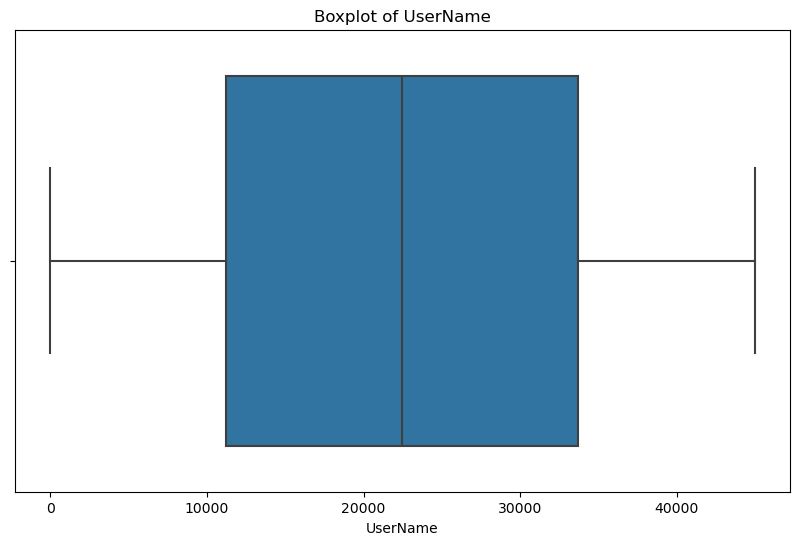

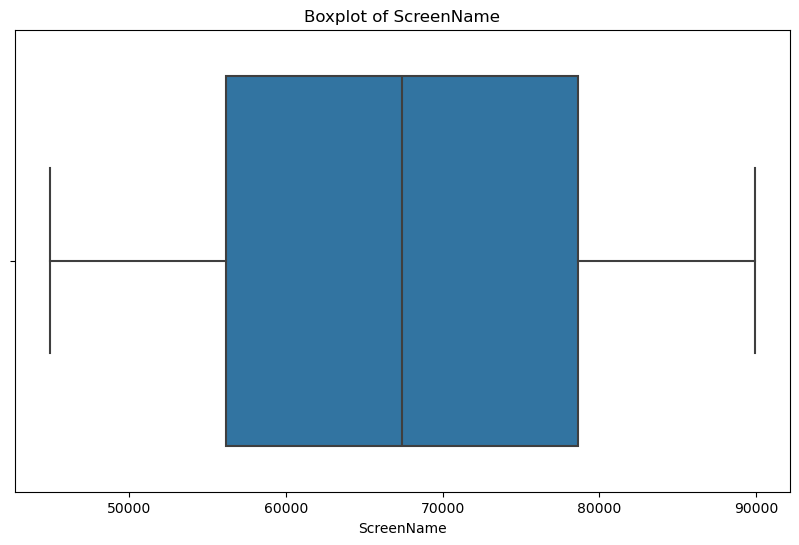

In [88]:
numerical = list(train_df.select_dtypes(include=['int64', 'float64']).columns)

# Boxplot for each variable in numerical list

for col in numerical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [89]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'


In [90]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

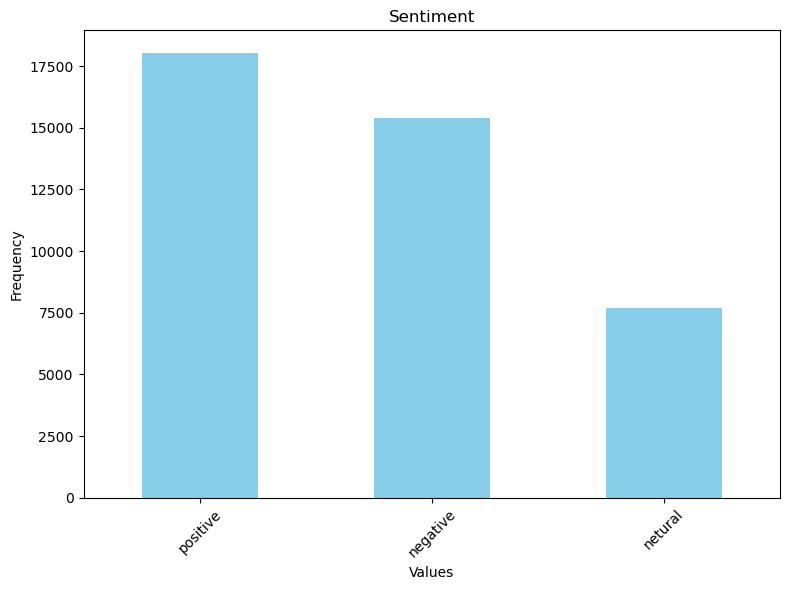

In [91]:
value_counts = train_df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:

#drop unecessary columns
columns_to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']

for col in columns_to_drop:
    if col in train_df.columns:
        train_df.drop(columns=[col], inplace=True)
    if col in test_df.columns:
        test_df.drop(columns=[col], inplace=True)

label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['Sentiment'])
test_df['sentiment_encoded'] = label_encoder.fit_transform(test_df['Sentiment'])



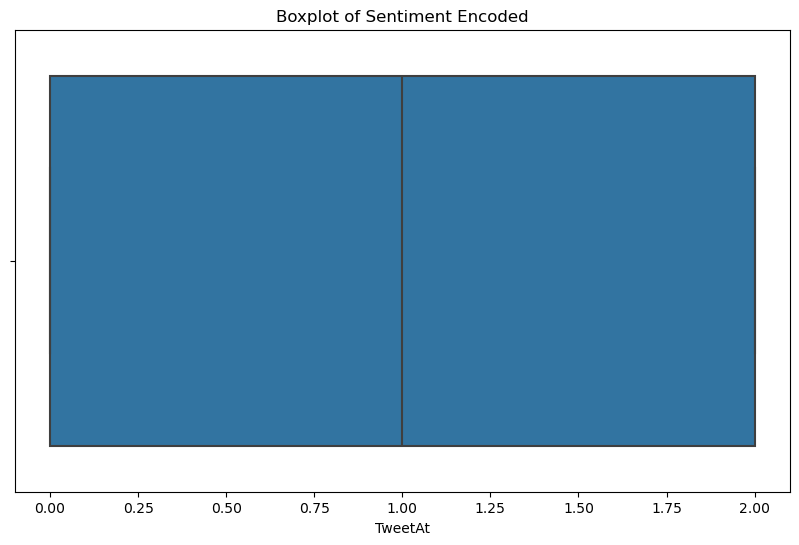

In [93]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['sentiment_encoded'])
plt.title('Boxplot of Sentiment Encoded')
plt.xlabel(col)
plt.show()

In [94]:
#Applying Preprocessing Steps to our target column

train_df["Final_Tweet"]=train_df['OriginalTweet'].apply(preprocess_tweet)

test_df["Final_Tweet"]=test_df['OriginalTweet'].apply(preprocess_tweet)

In [95]:
train_df.head()

,OriginalTweet,Sentiment,sentiment_encoded,Final_Tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,netural,1,menyrbie philgahan chrisitv
1,advice Talk to your neighbours family to excha...,positive,2,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,positive,2,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,positive,2,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",negative,0,ready go supermarket covid outbreak im paranoi...


In [96]:
test_df.head()

,OriginalTweet,Sentiment,sentiment_encoded,Final_Tweet
0,TRENDING: New Yorkers encounter empty supermar...,negative,0,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,positive,2,couldnt find hand sanitizer fred meyer turned ...
2,Find out how you can protect yourself and love...,positive,2,find protect loved one coronavirus
3,#Panic buying hits #NewYork City as anxious sh...,negative,0,panic buying hit newyork city anxious shopper ...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,netural,1,toiletpaper dunnypaper coronavirus coronavirus...


In [97]:
#After Preprocessing we dont need Original_Tweet Column so we drop it
if 'OriginalTweet' in train_df.columns:
 train_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)
if 'OriginalTweet' in test_df.columns:
 test_df.drop(columns=['OriginalTweet'], axis=1, inplace=True)

## Apllying Padding

In [98]:
#tokeniser splits our tweets into individual words/subwords
tokenizer = Tokenizer()

#this step builds vocabulary of the tokenizer
tokenizer.fit_on_texts(train_df['Final_Tweet'])

#this step encodes each word of each tweet into an integer sequence
X_train = tokenizer.texts_to_sequences(train_df['Final_Tweet'])
X_test = tokenizer.texts_to_sequences(test_df['Final_Tweet'])

In [99]:
#All tweet lengths
tweet_lengths = [len(tweet) for tweet in train_df['Final_Tweet']]
max_length = max(set(tweet_lengths), key=tweet_lengths.count) + 10

#padding seqeunce for both training and test data
X_train = pad_sequences(X_train, maxlen=max_length)
Y_train=train_df['sentiment_encoded']
X_test = pad_sequences(X_test, maxlen=max_length)
Y_test=test_df['sentiment_encoded']


max_length

180

## Model Architecture

In [100]:
vocab_size = len(tokenizer.word_index)
#Set maxlen based on the length of your input sequences
maxlen = max(len(seq) for seq in X_train)
#we have 5 classes of Sentiment
num_classes = len(label_encoder.classes_)

In [101]:
#+1 for the padding token
#output_dim represents the dimensionality of the word vectors (holding semantic meaning) to be used by model
#In Dense layer units=num_classes since it is meant to classify sentiments under 5 classes
# Used softmax because its an multi-classification problem
model = Sequential()
model.add(Embedding(input_dim=(vocab_size+1), output_dim=50))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=num_classes, activation='softmax'))

In [102]:
#Using sparse_categorical_crossentropy since we have encoded data in form of integers
#Using accuracy as metric since its an classification task
#optimizer determines how the model's weights are updated based on the loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

USING CALLBACK TO OPTIMIZE MODEL TRAINING PROCESS


In [103]:
#prevent overfitting by stopping the training process early
# number of epochs to wait before stopping the training process if no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [104]:
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=20, batch_size=64, callbacks=[early_stopping])

# Save the model
model.save("early.keras")

Epoch 1/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 411s 621ms/step - accuracy: 0.5868 - loss: 0.8532 - val_accuracy: 0.7994 - val_loss: 0.5379
Epoch 2/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 373s 579ms/step - accuracy: 0.8743 - loss: 0.3701 - val_accuracy: 0.8167 - val_loss: 0.5114
Epoch 3/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 391s 607ms/step - accuracy: 0.9234 - loss: 0.2395 - val_accuracy: 0.8160 - val_loss: 0.5509
Epoch 4/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 397s 616ms/step - accuracy: 0.9428 - loss: 0.1820 - val_accuracy: 0.8075 - val_loss: 0.6234
Epoch 5/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 396s 614ms/step - accuracy: 0.9564 - loss: 0.1370 - val_accuracy: 0.7946 - val_loss: 0.6597
Epoch 6/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 384s 597ms/step - accuracy: 0.9640 - loss: 0.1122 - val_accuracy: 0.7959 - val_loss: 0.7458
Epoch 7/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 386s 599ms/step - accuracy: 0.9698 - loss: 0.0964 - val_accuracy: 0.7915 - val_loss: 0.8130


In [106]:
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=2)

In [109]:
# Train the model with the ModelCheckpoint callback
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9933 - loss: 0.0225
Epoch 1: val_accuracy did not improve from 0.80885
644/644 ━━━━━━━━━━━━━━━━━━━━ 261s 406ms/step - accuracy: 0.9933 - loss: 0.0225 - val_accuracy: 0.7715 - val_loss: 1.3492
Epoch 2/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9960 - loss: 0.0136
Epoch 2: val_accuracy did not improve from 0.80885
644/644 ━━━━━━━━━━━━━━━━━━━━ 265s 412ms/step - accuracy: 0.9960 - loss: 0.0136 - val_accuracy: 0.7709 - val_loss: 1.3892
Epoch 3/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9959 - loss: 0.0143
Epoch 3: val_accuracy did not improve from 0.80885
644/644 ━━━━━━━━━━━━━━━━━━━━ 264s 410ms/step - accuracy: 0.9959 - loss: 0.0143 - val_accuracy: 0.7638 - val_loss: 1.4337
Epoch 4/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9965 - loss: 0.0120
Epoch 4: val_accuracy did not improve from 0.80885
644/644 ━━━━━━━━━━━━━━━━━━━━ 266s 412ms/step - accuracy: 0.9965 - loss: 0.0120 - 

In [110]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Print the model summary
print(model.summary())

119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7697 - loss: 1.8818
Test Loss: 1.966674566268921
Test Accuracy: 0.7617166638374329


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 180, 50)             │       2,673,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         183,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,573,753 (32.71 MB)

 Trainable params: 2,857,917 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,715,836 (21.80 MB)

None
